In [2]:
from manim import *
import jupyter_capture_output

video_scene = f" -v WARNING --disable_caching cf_Scene"
image_scene = f" -v WARNING --disable_caching -r {2*427},{2*240}  -s cf_Scene"

Manim Community v0.17.3

Jupyter Capture Output v0.0.11


In [53]:
class IncomingSigmal(Mobject):
    def __init__(self, omega_xyc, position, **kwargs):
        super().__init__(**kwargs)
        self.omega_x = omega_xyc[0]
        self.omega_y = omega_xyc[1]
        self.omega_c = omega_xyc[2]


class FTransformedImage(Mobject):
    def __init__(self, position, size, **kwargs):
        super().__init__(**kwargs)
        self.grid_center = position
        self.grid_sidelength = size
        self.grid_pixels = 128
        self.grid_node_dist = self.grid_sidelength / (self.grid_pixels + 1)
        self.grid_origin = self.grid_center + np.array([-self.grid_sidelength/2 + self.grid_node_dist, -self.grid_sidelength/2 + self.grid_node_dist, 0]) 

        # square with text
        square = Square(side_length = self.grid_sidelength, stroke_width = 1, stroke_color = BLACK, **kwargs).move_to(self.grid_center)
        square_text_head = Tex(r"Originales Bild", font_size = 32, color = BLACK).next_to(square, 0.5*UP)

        # x-axis
        x_line = Line(start = self.grid_origin + np.array([0, -0.25, 0]), end = self.grid_origin + np.array([self.grid_sidelength-2*self.grid_node_dist, -0.25, 0]), color = BLACK, stroke_width = 2)
        

        x_label = Tex(r"$x$", font_size = 32, color = BLACK).next_to(x_line, 0.5*DOWN)
        x0_line = Line(start = self.grid_origin + np.array([0, -0.125, 0]), end = self.grid_origin + np.array([0, -0.375, 0]), color = BLACK, stroke_width = 2)
        x1_line = Line(start = self.grid_origin + np.array([self.grid_sidelength-2*self.grid_node_dist, -0.125, 0]), end = self.grid_origin + np.array([self.grid_sidelength-2*self.grid_node_dist, -0.375, 0]), color = BLACK, stroke_width = 2)
        x_line_group = VGroup(x_line, x_label, x0_line, x1_line)
        
        # y-axis
        y_line = Line(start = self.grid_origin + np.array([-0.25, 0, 0]), end = self.grid_origin + np.array([-0.25, self.grid_sidelength-2*self.grid_node_dist, 0]), color = BLACK, stroke_width = 2)
        y_label = Tex(r"$y$", font_size = 32, color = BLACK).next_to(y_line, 0.5*LEFT)
        y0_line = Line(start = self.grid_origin + np.array([-0.125, 0, 0]), end = self.grid_origin + np.array([-0.375, 0, 0]), color = BLACK, stroke_width = 2)
        y1_line = Line(start = self.grid_origin + np.array([-0.125, self.grid_sidelength-2*self.grid_node_dist, 0]), end = self.grid_origin + np.array([-0.375, self.grid_sidelength-2*self.grid_node_dist, 0]), color = BLACK, stroke_width = 2)
        y_line_group = VGroup(y_line, y_label, y0_line, y1_line)

        
        self.add(square, square_text_head)#, x_line_group, y_line_group)

    # function to create a pixel for a given tupel of frequencies (omega_x, omega_y, omega_c)
    def get_pixel(self, omega_xyc):
        omega_x = omega_xyc[0]
        omega_y = omega_xyc[1]
        omega_c = omega_xyc[2]

        node_position = self.grid_origin + np.array([omega_x, omega_y-128, 0])  * self.grid_node_dist
        return 
        



    # def get_grid_coordinates(i_row, j_colum):
    #     grid_top_left_node = GRID_CENTER + np.array([-GRID_SIDE_LENGTH / 2 + GRID_NODE_DIST, GRID_SIDE_LENGTH / 2 - GRID_NODE_DIST, 0])
    #     return grid_top_left_node + np.array([j_colum, -i_row, 0])  * GRID_NODE_DIST


Output saved by creating file at animations/christmas_fourier/christmas_fourier.mp4.


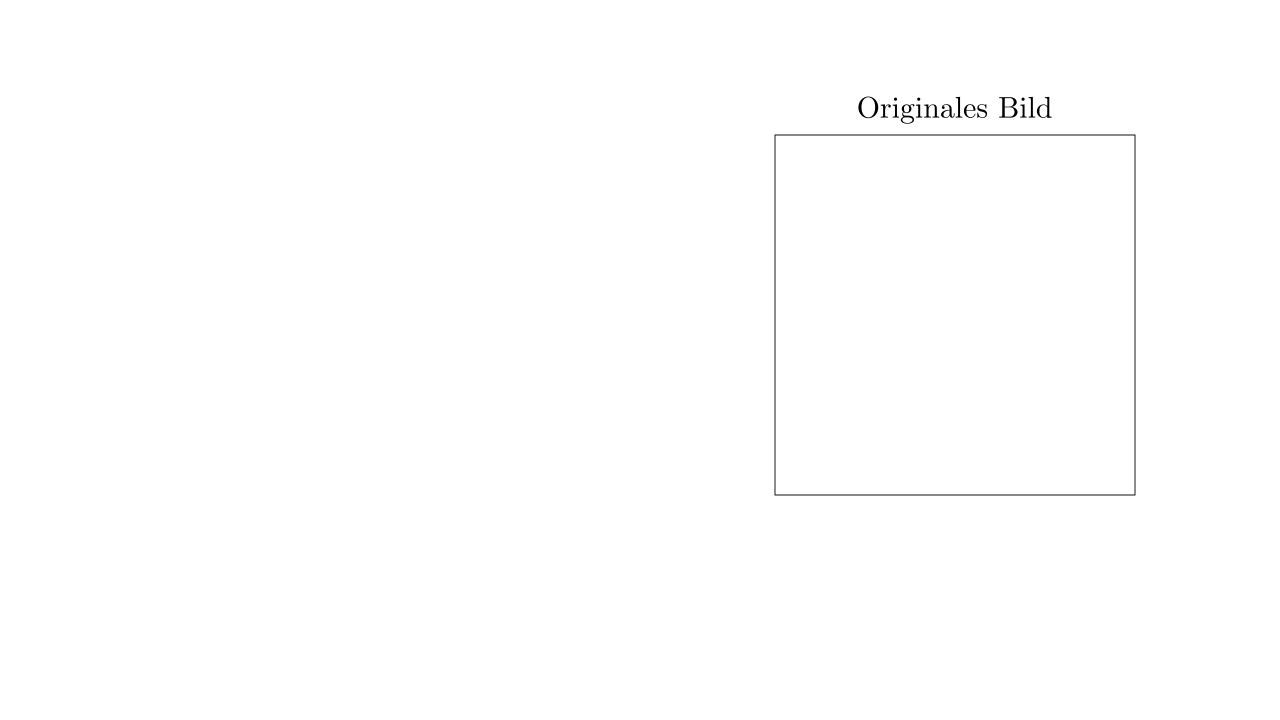

In [54]:
%%capture_video --path "animations/christmas_fourier/christmas_fourier.mp4"
%%manim -qm --fps 20 $video_scene


class cf_Scene(Scene):
    def construct(self):
        self.camera.background_color = WHITE

        image = FTransformedImage(position = np.array([3.5, 0.5, 0]), size = 4)
        self.add(image)